In [1]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count

import cProfile
from datetime import datetime

from tqdm import tqdm
from collections import defaultdict
from collections import deque
from collections.abc import Iterable
from copy import deepcopy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

In [2]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=3, n_cols=3, n_win=3):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def _check_terminal(self, cur_p):
        cur_marks = np.where(self.board == cur_p)
        for i,j in zip(cur_marks[0], cur_marks[1]):
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    return True
            if j <= self.n_cols - self.n_win:
                if np.all(self.board[i,j:j+self.n_win] == cur_p):
                    return True
            if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                    return True
            if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                    return True
        return False
    
    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_win = self._check_terminal(self.curTurn)
        if cur_win:
                self.gameOver = True
                return self.curTurn
            
        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def getWinner(self):
        # фактически запускаем isTerminal два раза для крестиков и ноликов
        if self._check_terminal(1):
            return 1
        if self._check_terminal(-1):
            return -1
        if len(self.getEmptySpaces()) == 0:
            return 0
        return None
    
    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [3]:
CROSSES = 1
NOUGHTS = -1
DRAW = 0
ENV_3 = TicTacToe(n_rows=3, n_cols=3, n_win=3)
ENV_4 = TicTacToe(n_rows=4, n_cols=4, n_win=4)
ENV_5 = TicTacToe(n_rows=5, n_cols=5, n_win=5)

## 1. Q-learning for TicTacToe

In [4]:
class RandomPolicy:
    def select_action(self, state, *arguments):
        _, empty_spaces, _ = state
        return np.random.randint(len(empty_spaces))
    
class EpsGreedyPolicy:
    def __init__(self):
        self.Q = {}

    def select_action(self, state, eps=0, *arguments):
        board_hash, empty_spaces, _ = state

        if random.random() >= eps and board_hash in self.Q:
            return np.argmax(self.Q[board_hash])

        if board_hash not in self.Q:
            self.Q[board_hash] = np.zeros(len(empty_spaces))

        return np.random.randint(len(empty_spaces))


In [5]:
def run_episode(env, policies, eps=0):
    env.reset()
    state = env.getState()
    _, empty_spaces, cur_turn = state

    done = False
    while not done:
        action = policies[cur_turn].select_action(state, eps, cur_turn)
        if not isinstance(action, tuple):
            action = empty_spaces[action]
        state, reward, done, _ = env.step(action)
        _, empty_spaces, cur_turn = state
    return reward

In [6]:
def evaluate(env, policies, num_experiments=50, show_progress=True):
    crosses_wins = 0
    noughts_wins = 0
    draws = 0
    
    for i in tqdm(range(num_experiments), disable=not show_progress):
        reward = run_episode(env, policies)
        crosses_wins += int(reward == CROSSES)
        noughts_wins += int(reward == NOUGHTS)
        draws += int(reward == DRAW)
    
    crosses_wins /= num_experiments
    noughts_wins /= num_experiments
    draws /= num_experiments

    return (crosses_wins, noughts_wins, draws)

In [7]:
def q_learning_episode(env, policies, alpha=0.1, gamma=1, eps=0.8):
    prev_dict = {
        agent: {"action_index": None, "board_hash": None}
        for agent in policies
    }

    env.reset()
    state = env.getState()
    board_hash, empty_spaces, cur_turn = state

    done = False
    while not done:
        action_index = policies[cur_turn].select_action(state,  eps)
        state, reward, done, _ = env.step(empty_spaces[action_index])
        if reward == cur_turn:
            policies[cur_turn].Q[board_hash][action_index] = abs(reward)

        next_board_hash, next_empty_spaces, next_turn = state
        prev_board_hash = prev_dict[next_turn]["board_hash"]
        prev_action_index = prev_dict[next_turn]["action_index"]
        if prev_board_hash is not None:
            reward = next_turn * reward
            gamma_term = gamma * np.max(policies[next_turn].Q[next_board_hash]) \
                         if next_board_hash in policies[next_turn].Q else 0
            policies[next_turn].Q[prev_board_hash][prev_action_index] += alpha * (
                reward + gamma_term
                - policies[next_turn].Q[prev_board_hash][prev_action_index]
            )

        prev_dict[cur_turn] = {"action_index": action_index, "board_hash": board_hash}
        board_hash, empty_spaces, cur_turn = next_board_hash, next_empty_spaces, next_turn

    return policies

In [8]:
def q_learning(env, policies, num_episodes=5000, alpha=0.05, gamma=1, eps_init=0.9,
               eps_final=0.2, eps_decay=3000, evaluate_every=250, eval_qty=200,
               show_progress=True):
    crosses_stats = {'wins': [], 'loses': [], 'draws': [], 'indexes' : []}
    noughts_stats = {'wins': [], 'loses': [], 'draws': [], 'indexes' : []}

    for i in tqdm(range(num_episodes), disable=not show_progress):
        eps = eps_init + (eps_final - eps_init) * i / eps_decay
        policies = q_learning_episode(env, policies, alpha, gamma, eps)

        if (i + 1) % evaluate_every == 0:
            crosses_wins, noughts_wins, draws = evaluate(env,
                                                         policies={CROSSES: policies[CROSSES],
                                                                   NOUGHTS: RandomPolicy()},
                                                         num_experiments=eval_qty,
                                                         show_progress=False)
            crosses_stats["indexes"].append(i + 1)
            crosses_stats["wins"].append(crosses_wins)
            crosses_stats["loses"].append(noughts_wins)
            crosses_stats["draws"].append(draws)
            
            crosses_wins, noughts_wins, draws = evaluate(env,
                                                         policies={CROSSES: RandomPolicy(),
                                                                   NOUGHTS: policies[NOUGHTS]},
                                                         num_experiments=eval_qty,
                                                         show_progress=False)
            noughts_stats["indexes"].append(i + 1)
            noughts_stats["wins"].append(noughts_wins)
            noughts_stats["loses"].append(crosses_wins)
            noughts_stats["draws"].append(draws)

    return crosses_stats, noughts_stats

In [9]:
def plot_stats(stats, fig_name=''):
    plt.figure(figsize=(12, 6))
    plt.title(fig_name)
    plt.xlabel('Learning episodes')
    plt.ylabel('Win rate')
    plt.grid(True)
    plt.plot([0] + stats["indexes"], [0] + stats["wins"], label='Wins')
    plt.plot([0] + stats["indexes"], [0] + stats["loses"], label='Loses')
    plt.plot([0] + stats["indexes"], [0] + stats["draws"], label='Draws')
    plt.legend()

### 1) Q-learning for 3x3 board

In [10]:
policies = {NOUGHTS: EpsGreedyPolicy(), CROSSES: EpsGreedyPolicy()}

crosses_stats, noughts_stats = q_learning(ENV_3, policies, num_episodes=50000, gamma=1, eps_decay=25000, 
                                          evaluate_every=500, eval_qty=200
                                         )

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:41<00:00, 1190.94it/s]


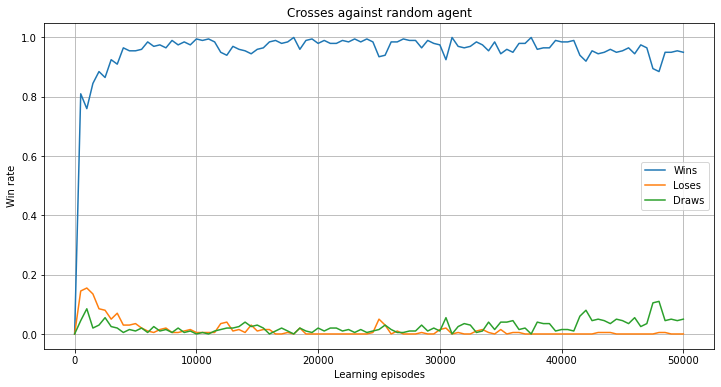

In [11]:
plot_stats(crosses_stats, 'Crosses against random agent')

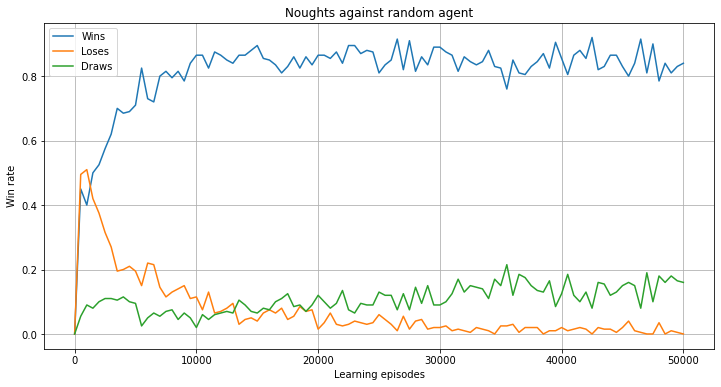

In [12]:
plot_stats(noughts_stats, 'Noughts against random agent')

In [13]:
ENV_3_Q_CROSSES = deepcopy(policies[CROSSES])
ENV_3_Q_NOUGHTS = deepcopy(policies[NOUGHTS])

### 2) Q-learning for 4x4 board

In [14]:
policies = {NOUGHTS: EpsGreedyPolicy(), CROSSES: EpsGreedyPolicy()}

crosses_stats, noughts_stats = q_learning(ENV_4, policies, num_episodes=500000, gamma=1, eps_decay=500000, 
                                          evaluate_every=1000, eval_qty=200
                                         )

100%|█████████████████████████████████████████████████████████████████████████| 500000/500000 [13:49<00:00, 602.51it/s]


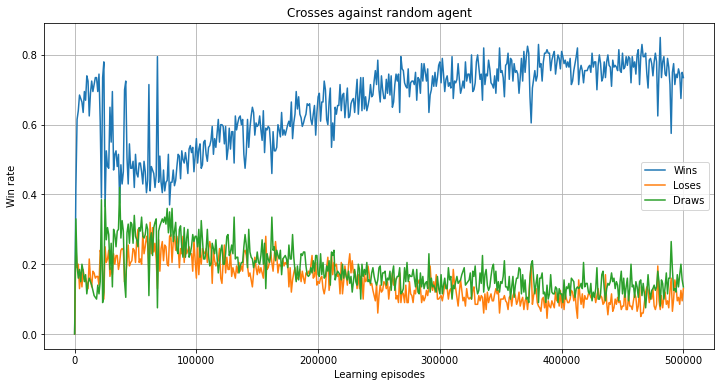

In [15]:
plot_stats(crosses_stats, 'Crosses against random agent')

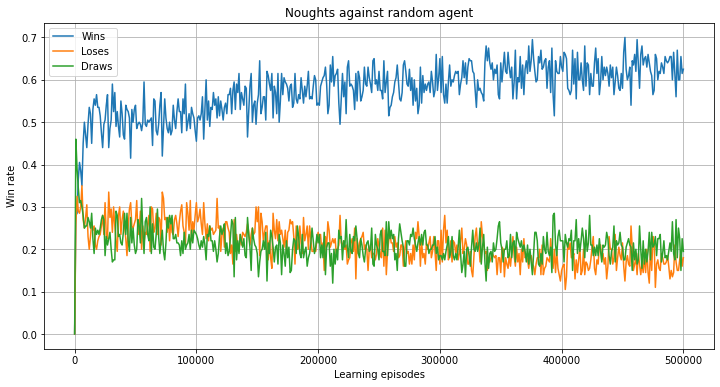

In [16]:
plot_stats(noughts_stats, 'Noughts against random agent')

In [17]:
ENV_4_Q_CROSSES = deepcopy(policies[CROSSES])
ENV_4_Q_NOUGHTS = deepcopy(policies[NOUGHTS])

## 2. DQN

In [61]:
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def save(self, transition):
        """Save a transition"""
        self.memory.append(transition)

    def sample(self, batch_size: int = 64):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    
class ConvNet(nn.Module):
    def __init__(self, output_dim, hidden_dim=32):
        super().__init__()
        self.conv_1 = nn.Conv2d(
            in_channels=3,
            out_channels=hidden_dim,
            kernel_size=(3, 3),
            padding=1
        )
        self.conv_2 = nn.Conv2d(
            in_channels=hidden_dim,
            out_channels=hidden_dim,
            kernel_size=(3, 3),
            padding=1
        )
        self.activation = nn.ReLU()
        self.linear = nn.Linear(
            in_features=hidden_dim * output_dim,
            out_features=output_dim
        )

    def forward(self, x):
        x = self.conv_1(x)
        x = self.activation(x)
        x = self.conv_2(x)
        x = self.activation(x)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return x

class DQN:
    def __init__(self, env, model: nn.Module):
        self.env = env
        self.n_rows = self.env.n_rows
        self.n_cols = self.env.n_cols
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.models = {CROSSES: model(output_dim=self.n_rows * self.n_cols).to(self.device),
                       NOUGHTS: model(output_dim=self.n_rows * self.n_cols).to(self.device)
                      }

        self.num_step = 0

    def board_to_tensor(self, board_hash):
        board = np.array([float(cell) for cell in board_hash]).reshape(
            (self.n_rows, self.n_cols)
        )
        crosses = torch.FloatTensor(board == 2)
        noughts = torch.FloatTensor(board == 0)
        empty_spaces = torch.FloatTensor(board == 1)
        return torch.stack((crosses, noughts, empty_spaces))

    def select_action(self, state, eps=0, player=None):
        board_hash, _, _ = state
        board_tensor = self.board_to_tensor(board_hash).to(self.device)
        if random.random() >= eps:
            action_index = self.models[player](board_tensor.unsqueeze(0)).max(dim=1)[1].view(1,1)
            return self.env.action_from_int(action_index)
        else:
            action_index = random.randrange(self.n_rows * self.n_cols)
            return self.env.action_from_int(action_index)


def optimization_step(dqn, memories, criterion, optimizers, cur_turn, batch_size=64, gamma=0.9):
    if np.min([len(memories[cur_turn]), len(memories[-cur_turn])]) < batch_size:
        return

    transitions = memories[cur_turn].sample(batch_size)
    batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)
    # adding to computational graph
    batch_state = Variable(torch.stack(batch_state).to(dqn.device))
    batch_action = Variable(torch.cat(batch_action).to(dqn.device))
    batch_reward = Variable(torch.cat(batch_reward).to(dqn.device))
    batch_next_state = Variable(torch.stack(batch_next_state).to(dqn.device))

    state_action_values  = dqn.models[cur_turn](batch_state).gather(1, batch_action).reshape([batch_size])
    next_state_values = dqn.models[cur_turn](batch_next_state).max(1)[0].detach()
    expected_state_action_values = gamma * next_state_values + batch_reward

    optimizers[cur_turn].zero_grad()
    loss = criterion(state_action_values, expected_state_action_values)
    loss.backward()
    for param in dqn.models[cur_turn].parameters():
        param.grad.data.clamp_(-0.1, 0.1)
    optimizers[cur_turn].step()

In [67]:
def dqn_training_step(dqn, criterion, optimizers, memories, batch_size=128,
                      eps_init= 0.9, eps_final=0.2, eps_decay=5000, gamma=0.7):
    dqn.env.reset()
    previous_states = {CROSSES: None, NOUGHTS: None}
    previous_actions = {}
    state = dqn.env.getState()
    board_hash, _, cur_turn = state

    done = False
    while not done:
        board_tensor = dqn.board_to_tensor(board_hash).to(dqn.device)
        dqn.num_step += 1
        eps = eps_init + (eps_final - eps_init) * dqn.num_step / eps_decay
        with torch.no_grad():
            action = dqn.select_action(state, eps, cur_turn)

        action_index = torch.tensor(
            dqn.env.int_from_action(action),
            device=dqn.device,
            dtype=torch.long
        ).view(1, 1)
        previous_states[cur_turn] = board_tensor
        previous_actions[cur_turn] = action_index
        state, reward, done, _ = dqn.env.step(action)
        next_board_hash, _, cur_turn = state
        board_hash = next_board_hash
        next_board_tensor = dqn.board_to_tensor(next_board_hash)
        if reward == -10:
            transition = (board_tensor, action_index, next_board_tensor, torch.tensor([-10], dtype=torch.float32))
            memories[cur_turn].save(transition)
        else:
            if previous_states[cur_turn] is not None:
                if reward == -cur_turn: #win case
                    transition = (previous_states[-cur_turn], previous_actions[-cur_turn],
                                    next_board_tensor, torch.tensor([1.0], dtype=torch.float32))
                    memories[-cur_turn].save(transition)
                #lose or zero case
                transition = (previous_states[cur_turn], previous_actions[cur_turn],
                                next_board_tensor, torch.tensor([reward * cur_turn], dtype=torch.float32))
                memories[cur_turn].save(transition)

        optimization_step(dqn, memories, criterion, optimizers, cur_turn, batch_size, gamma)

In [68]:
def train_dqn(dqn, num_epochs=10000, learning_rate=1e-4, batch_size=64,
              weight_decay=1e-5, memory_size=5000, eps_init=0.9, eps_final=0.1,
              eps_decay=5000, evaluate_every=250, eval_qty=200,
              show_progress=True):
    crosses_stats = {'wins': [], 'loses': [], 'draws': [], 'indexes' : []}
    noughts_stats = {'wins': [], 'loses': [], 'draws': [], 'indexes' : []}
    memories = {CROSSES: ReplayMemory(memory_size), NOUGHTS: ReplayMemory(memory_size)}
    criterion = torch.nn.HuberLoss()
    optimizers = {CROSSES: optim.Adam(dqn.models[CROSSES].parameters(),lr=learning_rate,weight_decay=weight_decay),
                  NOUGHTS: optim.Adam(dqn.models[NOUGHTS].parameters(),lr=learning_rate,weight_decay=weight_decay)
                 }

    for i in tqdm(range(num_epochs), disable=not show_progress):
        dqn_training_step(dqn, criterion, optimizers, memories,
                          batch_size, eps_init, eps_final, eps_decay)
        if (i + 1) % evaluate_every == 0:
            crosses_wins, noughts_wins, draws = evaluate(dqn.env, policies={CROSSES: dqn, NOUGHTS: RandomPolicy()},
                                                         num_experiments=eval_qty, show_progress=False
                                                        )
            crosses_stats["indexes"].append(i + 1)
            crosses_stats["wins"].append(crosses_wins)
            crosses_stats["loses"].append(noughts_wins)
            crosses_stats["draws"].append(draws)
            
            crosses_wins, noughts_wins, draws = evaluate(dqn.env, policies={CROSSES: RandomPolicy(), NOUGHTS: dqn},
                                                         num_experiments=eval_qty, show_progress=False
                                                        )
            noughts_stats["indexes"].append(i + 1)
            noughts_stats["wins"].append(noughts_wins)
            noughts_stats["loses"].append(crosses_wins)
            noughts_stats["draws"].append(draws)
    
    return crosses_stats, noughts_stats

### 3) DQN for 3x3 and 4x4 boards

In [72]:
dqn = DQN(env=ENV_3, model=ConvNet)

crosses_stats, noughts_stats = train_dqn(dqn, num_epochs=10000, eps_decay=10000,
                                         evaluate_every=250, eval_qty=200)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [07:09<00:00, 23.28it/s]


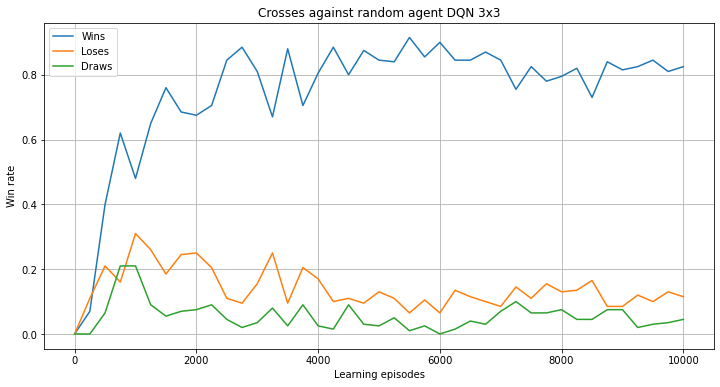

In [73]:
plot_stats(crosses_stats, 'Crosses against random agent DQN 3x3')

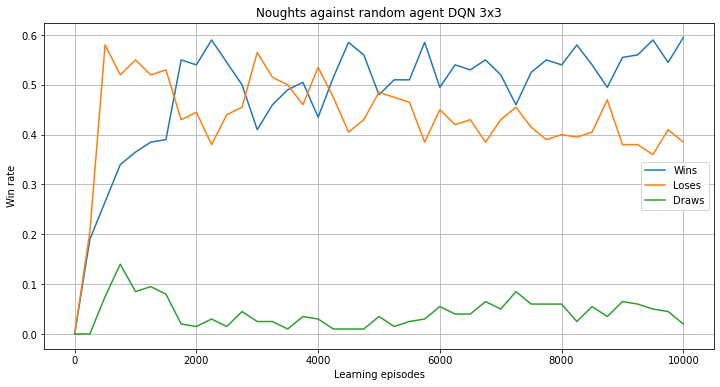

In [74]:
plot_stats(noughts_stats, 'Noughts against random agent DQN 3x3')

In [75]:
dqn = DQN(env=ENV_4, model=ConvNet)

crosses_stats, noughts_stats = train_dqn(dqn, num_epochs=20000, eps_decay=20000,
                                         evaluate_every=400, eval_qty=200)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [27:57<00:00, 11.92it/s]


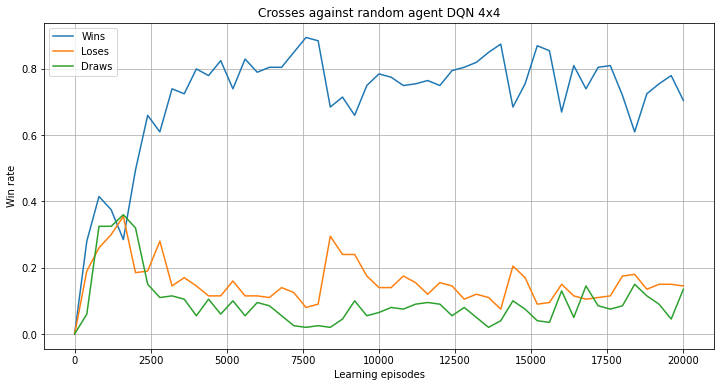

In [76]:
plot_stats(crosses_stats, 'Crosses against random agent DQN 4x4')

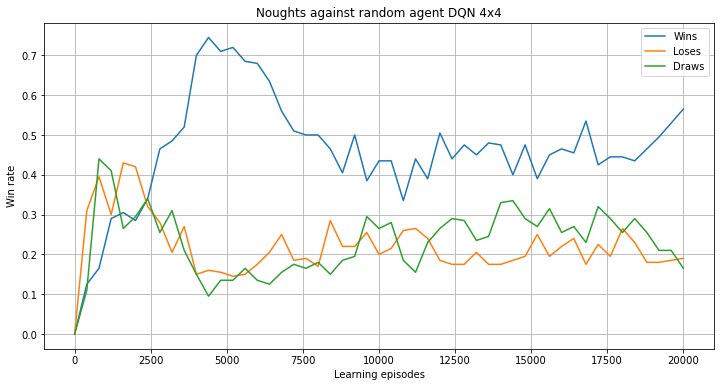

In [77]:
plot_stats(noughts_stats, 'Noughts against random agent DQN 4x4')

### 4) Dueling DQN for 3x3 and 4x4 boards

In [78]:
class ConvNetDDQN(nn.Module):
    def __init__(self, output_dim, hidden_dim=24):
        super().__init__()
        self.conv_1 = nn.Conv2d(
            in_channels=3,
            out_channels=hidden_dim * 2,
            kernel_size=(3, 3),
            padding=1
        )
        self.conv_2 = nn.Conv2d(
            in_channels=hidden_dim * 2,
            out_channels=hidden_dim * 2,
            kernel_size=(3, 3),
            padding=1
        )
        self.activation = nn.ReLU()
        self.linear = nn.Linear(
            in_features=hidden_dim * 2 * output_dim,
            out_features=hidden_dim * output_dim
        )
        self.advantage = nn.Linear(
            in_features=hidden_dim * output_dim,
            out_features=output_dim
        )
        self.value = nn.Linear(
            in_features=hidden_dim * output_dim,
            out_features=1
        )

    def forward(self, x):
        x = self.conv_1(x)
        x = self.activation(x)
        x = self.conv_2(x)
        x = self.activation(x)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        x = self.activation(x)
        value = self.value(x)
        advantage = self.advantage(x)
        x = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return x

In [79]:
dqn = DQN(env=ENV_3, model=ConvNetDDQN)

crosses_stats, noughts_stats = train_dqn(dqn, num_epochs=10000, eps_decay=10000,
                                         evaluate_every=400, eval_qty=200)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [14:12<00:00, 11.73it/s]


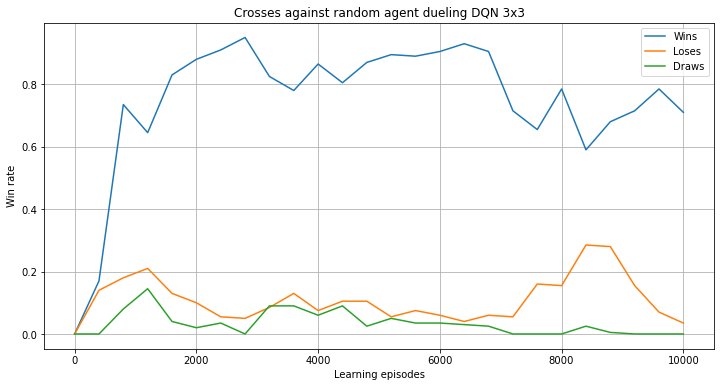

In [80]:
plot_stats(crosses_stats, 'Crosses against random agent dueling DQN 3x3')

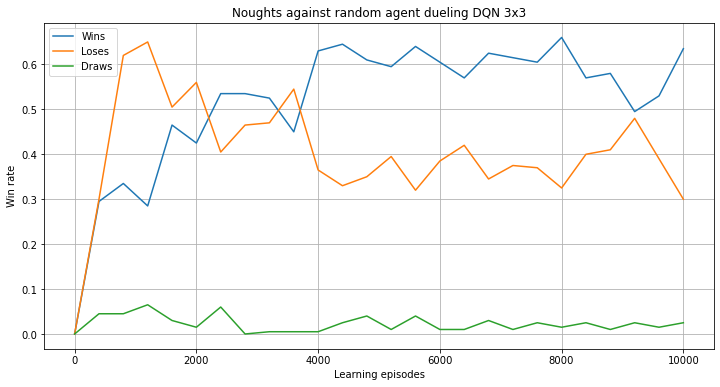

In [81]:
plot_stats(noughts_stats, 'Noughts against random agent dueling DQN 3x3')

In [85]:
dqn = DQN(env=ENV_4, model=ConvNetDDQN)

crosses_stats, noughts_stats = train_dqn(dqn, num_epochs=5000, eps_decay=10000,
                                         evaluate_every=400, eval_qty=200)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [13:47<00:00,  6.04it/s]


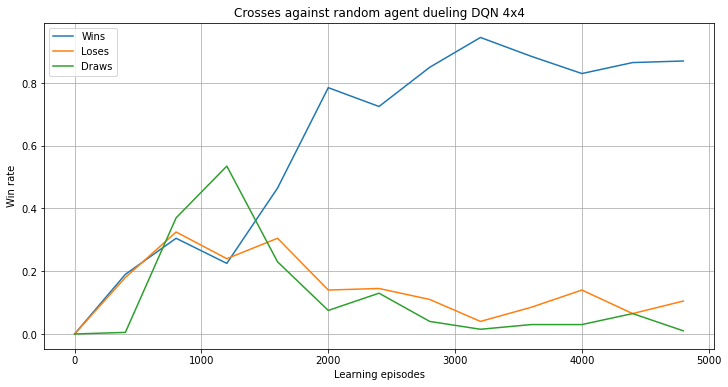

In [86]:
plot_stats(crosses_stats, 'Crosses against random agent dueling DQN 4x4')

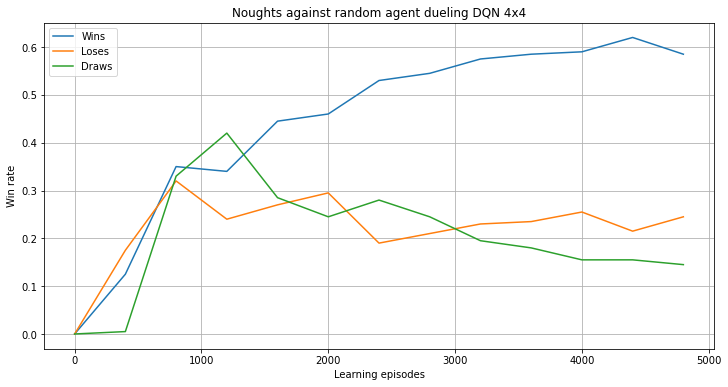

In [87]:
plot_stats(noughts_stats, 'Noughts against random agent dueling DQN 4x4')

## 3. Rollouts and MCTS

### 5) Rollouts

In [88]:
def rollout(env, action, policies, num_rollouts=20):
    total_reward = 0
    for _ in range(num_rollouts):
        env_copy = deepcopy(env)
        state, reward, done, _ = env_copy.step(action)
        _, empty_spaces, cur_turn = state

        while not done:
            action_index = policies[cur_turn].select_action(state, cur_turn)
            state, reward, done, _ = env_copy.step(empty_spaces[action_index])
            _, empty_spaces, cur_turn = state

        total_reward += reward

    return total_reward / num_rollouts

def run_episode_with_rollouts(env, policies, num_rollouts=20):
    pi = RandomPolicy()
    env.reset()
    state = env.getState()
    _, empty_spaces, cur_turn = state
    reward = 0

    done = False
    while not done:
        if policies[cur_turn] is not None:
            best_reward = -10
            action_index = 0
            for i, action in enumerate(empty_spaces):
                avg_reward = cur_turn * rollout(
                    env, action,
                    {cur_turn: policies[cur_turn], -cur_turn: pi},
                    num_rollouts=num_rollouts
                )
                if avg_reward > best_reward:
                    best_reward = avg_reward
                    action_index = i
        else:
            action_index = pi.select_action(state)
        state, reward, done, _ = env.step(empty_spaces[action_index])
        _, empty_spaces, cur_turn = state

    return reward

def test_rollouts(env, policies, num_episodes=100, num_rollouts=40, show_progress=True):
    crosses_wins = 0
    noughts_wins = 0
    draws = 0
    for _ in tqdm(range(num_episodes), disable=not show_progress):
        reward = run_episode_with_rollouts(env, policies, num_rollouts)
        crosses_wins += int(reward == CROSSES)
        noughts_wins += int(reward == NOUGHTS)
        draws += int(reward==DRAW)

    print(f"Average winrate of crosses: {100 * crosses_wins / num_episodes:.2f} %")
    print(f"Average winrate of noughts: {100 * noughts_wins / num_episodes:.2f} %")
    print(f"Average amount of draws: {100 * draws / num_episodes:.2f} %")

In [89]:
# rollouts with random policy for crosses against random policy, 3x3 field

test_rollouts(
    ENV_3,
    policies={CROSSES: RandomPolicy(), NOUGHTS: None},
    num_episodes=100
)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.91it/s]

Average winrate of crosses: 98.00 %
Average winrate of noughts: 0.00 %
Average amount of draws: 2.00 %


In [90]:
# rollouts with random policy for Noughts against random policy, 3x3 field

test_rollouts(
    ENV_3,
    policies={CROSSES: RandomPolicy(), NOUGHTS: None},
    num_episodes=100
)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.70it/s]

Average winrate of crosses: 98.00 %
Average winrate of noughts: 0.00 %
Average amount of draws: 2.00 %


In [91]:
# rollouts with policy trained with  Q learning for crosses against random policy, 4x4 field

test_rollouts(
    ENV_4,
    policies={CROSSES: ENV_4_Q_CROSSES, NOUGHTS: None},
    num_episodes=100
)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:14<00:00,  2.54s/it]

Average winrate of crosses: 97.00 %
Average winrate of noughts: 0.00 %
Average amount of draws: 3.00 %


In [92]:
# rollouts with policy trained with  Q learning for noughts against random policy, 4x4 field

test_rollouts(
    ENV_4,
    policies={CROSSES: None, NOUGHTS: ENV_4_Q_NOUGHTS},
    num_episodes=100
)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:10<00:00,  1.90s/it]

Average winrate of crosses: 0.00 %
Average winrate of noughts: 95.00 %
Average amount of draws: 5.00 %


Отлично работает, но очень медленно, для условного поля 10x10 одна игра будет длиться минут 5. 

### 6) MCTS

In [118]:
class MctsNode:
    def __init__(self, env, parent=None):
        self.env = deepcopy(env)
        self.is_terminal = self.env.isTerminal() is not None
        self.parent = parent
        self.children = []
        self.num_visits = 0
        self.reward = 0
        self.new_actions = list(self.env.getEmptySpaces())

    def select_best_child(self, exploration_coef: float = 1.0):
        children_scores = [
            child.reward / child.num_visits
            + exploration_coef * np.sqrt((np.log(self.num_visits) / child.num_visits))
            for child in self.children
        ]
        return np.argmax(children_scores)

    def expand(self):
        action = self.new_actions.pop(0)

        next_env = deepcopy(self.env)
        next_env.step(action)

        child_node = MctsNode(next_env, parent=self)
        self.children.append(child_node)

        return child_node

    def rollout(self):
        rollout_env = deepcopy(self.env)

        reward = rollout_env.isTerminal()
        empty_spaces = rollout_env.getEmptySpaces()

        done = self.is_terminal
        while not done:
            action = random.choice(empty_spaces)
            (_, empty_spaces, _), reward, done, _ = rollout_env.step(action)
        return reward * self.env.curTurn

    def backprop(self, reward):
        self.num_visits += 1
        self.reward -= reward
        if self.parent:
            self.parent.backprop(-reward)
            
class MctsPolicy:
    def __init__(self, env, num_simulations=200):
        self.env = env
        self.num_simulations = num_simulations

    def select_action(self, state, eps=0, player=None):
        tree_root = MctsNode(self.env)

        for _ in range(self.num_simulations):
            node = tree_root
            while not node.is_terminal:
                if len(node.new_actions) > 0:
                    node = node.expand()
                else:
                    node = node.children[node.select_best_child(exploration_coef=1.4)]
            reward = node.rollout()
            node.backprop(reward)
        return tree_root.select_best_child(exploration_coef=0)

In [136]:
mcts_3x3_c = MctsPolicy(ENV_3, num_simulations=80)
mcts_4x4_c = MctsPolicy(ENV_4, num_simulations=80)
mcts_3x3_n = MctsPolicy(ENV_3, num_simulations=140)
mcts_4x4_n = MctsPolicy(ENV_4, num_simulations=140)

In [137]:
w, l, d = evaluate(ENV_3, {CROSSES: mcts_3x3_c, NOUGHTS: RandomPolicy()}, num_experiments=200, show_progress=True)
print(f'MCTS win rate: {w}, loose rate {l}, draws rate {d} agains Noughts  with random policy at 3x3 board')

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:07<00:00,  2.98it/s]

MCTS win rate: 0.99, loose rate 0.0, draws rate 0.01 agains Noughts  with random policy at 3x3 board


In [138]:
l, w, d = evaluate(ENV_3, {CROSSES: RandomPolicy(), NOUGHTS: mcts_3x3_n}, num_experiments=200, show_progress=True)
print(f'MCTS win rate: {w}, loose rate {l}, draws rate {d} agains Crosses  with random policy at 3x3 board')

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:16<00:00,  2.61it/s]

MCTS win rate: 0.85, loose rate 0.07, draws rate 0.08 agains Crosses  with random policy at 3x3 board


In [139]:
w, l, d = evaluate(ENV_4, {CROSSES: mcts_4x4_c, NOUGHTS: RandomPolicy()}, num_experiments=200, show_progress=True)
print(f'MCTS win rate: {w}, loose rate {l}, draws rate {d} agains Noughts  with random policy at 4x4 board')

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [03:26<00:00,  1.03s/it]

MCTS win rate: 0.895, loose rate 0.0, draws rate 0.105 agains Noughts  with random policy at 4x4 board


In [140]:
l, w, d = evaluate(ENV_4, {CROSSES: RandomPolicy(), NOUGHTS: mcts_4x4_n}, num_experiments=200, show_progress=True)
print(f'MCTS win rate: {w}, loose rate {l}, draws rate {d} agains Crosses  with random policy at 4x4 board')

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [05:01<00:00,  1.51s/it]

MCTS win rate: 0.83, loose rate 0.0, draws rate 0.17 agains Crosses  with random policy at 4x4 board


1) Роллауты работают отлично но очень долго, с ростом сложности задачи становится нереально их использовать
2) Monte Carlo Tree Search для таких маленьких задач тоже показал себя отлично и что самое важное после обучения может работать быстро
3) DQN - результаты похуже, тяжело настроить обучение, но можно достаточно быстро обучить для больших задач
4) Q-learning потенциально может давать отличные результаты но очень долгое обучение